In [4]:

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import math
from tester import test_classifier, dump_classifier_and_data

import numpy as np
from numpy import log
from numpy import sqrt
from numpy import float64
from numpy import nan

from time import time
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split

from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.pipeline import Pipeline

from sklearn.decomposition import PCA

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.lda import LDA
from sklearn.neural_network import BernoulliRBM
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.cluster import KMeans
import matplotlib
import sys
import pickle
from feature_format import featureFormat, targetFeatureSplit
from sklearn.cross_validation import KFold
from sklearn.metrics import r2_score
from sklearn.feature_selection import SelectFromModel



### Created data_dict list containing all pickled data for analysis

In [5]:

import matplotlib
import sys
import pickle
sys.path.append("../tools/")

### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
features_list = ['poi','salary'] # You will need to use more features

### Load the dictionary containing the dataset
import pickle
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)


### Task 1
Created a list of all features 'features_all' from data_dict list and moved 'poi' to first position requred for function

In [50]:
features_all = []
for v in data_dict['WHALEY DAVID A']:
    features_all.append(v)
oldindex = features_all.index('poi')
features_all.insert(0, features_all.pop(oldindex))
print features_all
#print data_dict['SKILLING JEFFREY K']
len(features_all)
    

['poi', 'salary', 'to_messages', 'deferral_payments', 'total_payments', 'exercised_stock_options', 'bonus', 'restricted_stock', 'shared_receipt_with_poi', 'restricted_stock_deferred', 'total_stock_value', 'expenses', 'loan_advances', 'from_messages', 'other', 'from_this_person_to_poi', 'director_fees', 'deferred_income', 'long_term_incentive', 'email_address', 'from_poi_to_this_person']


21

In order to do EDA and deal with outliers we need to create dataframes. Dataframe is created where index (rows) is names and columns are all the features. In order to summarize the features and see the data we need to rename index to just a colum. 

### Rubric questions
* total number of data points
* allocation across classes (POI/non-POI)
* number of features used
* are there features with many missing values? etc.

### Task 2 Outliers
To identify outliers we need to transfer data to dataframe.
We identified three clear outliers (TOTAL,  THE TRAVEL AGENCY, LOCKHART EUGENE E ). THE TRAVEL AGENCY and TOTAL are not real persons and should be taken out.  Mr. Lockhart does not have any data to his name.


In [7]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import pandas as pd
def to_pandas(data_dict):
    df = pd.DataFrame(data_dict)
    df = df.convert_objects(convert_numeric=True) #converted objects to Numbeic, like POI which was boolean
    df = df.transpose() #original data_dict had all the info in rows instead of columns
    df.reset_index(level=0, inplace=True) #resets the index column to just a column
    columns = list(df.columns)
    columns[0] = 'name' #index column is renamed to names
    df.columns = columns
    return(df)
df = to_pandas(data_dict)
df.to_csv('dataset.csv')

/Users/azizmamatov/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


### Answers to rubric questions
* All emails adresses are NaN,
* 146 people, and 21 features.
* 128 non-POI and 18 POI
* Following names have this percentage of NaN values: 
* LOCKHART EUGENE E		95.238095
* GRAMM WENDY L	85.714286
* SCRIMSHAW MATTHEW	85.714286
* THE TRAVEL AGENCY IN THE PARK	85.714286
* WHALEY DAVID A	85.714286
* WODRASKA JOHN	85.714286
* WROBEL BRUCE	85.714286


In [8]:
df.shape
print df.groupby(['poi']).size() # we can see number of poi
df.describe()


poi
0.0    128
1.0     18
dtype: int64


/Users/azizmamatov/anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
count,8.200000e+01,3.900000e+01,4.900000e+01,1.700000e+01,0.0,1.020000e+02,9.500000e+01,86.000000,86.000000,86.000000,...,6.600000e+01,9.300000e+01,146.000000,1.100000e+02,1.800000e+01,9.500000e+01,86.000000,86.000000,1.250000e+02,1.260000e+02
mean,2.374235e+06,1.642674e+06,-1.140475e+06,1.668049e+05,NaN,5.987054e+06,1.087289e+05,608.790698,64.895349,41.232558,...,1.470361e+06,9.190650e+05,0.123288,2.321741e+06,1.664106e+05,5.621943e+05,1176.465116,2073.860465,5.081526e+06,6.773957e+06
std,1.071333e+07,5.161930e+06,4.025406e+06,3.198914e+05,NaN,3.106201e+07,5.335348e+05,1841.033949,86.979244,100.073111,...,5.942759e+06,4.589253e+06,0.329899,1.251828e+07,4.201494e+06,2.716369e+06,1178.317641,2582.700981,2.906172e+07,3.895777e+07
min,7.000000e+04,-1.025000e+05,-2.799289e+07,3.285000e+03,NaN,3.285000e+03,1.480000e+02,12.000000,0.000000,0.000000,...,6.922300e+04,2.000000e+00,0.000000,-2.604490e+06,-7.576788e+06,4.770000e+02,2.000000,57.000000,1.480000e+02,-4.409300e+04
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,9.734362e+07,3.208340e+07,-8.330000e+02,1.398517e+06,NaN,3.117640e+08,5.235198e+06,14368.000000,528.000000,609.000000,...,4.852193e+07,4.266759e+07,1.000000,1.303223e+08,1.545629e+07,2.670423e+07,5521.000000,15149.000000,3.098866e+08,4.345095e+08


### 'Total' outlier.
Total is just a sum of values and should be taken out

In [9]:
df['name'].groupby(df['salary']).max()
df.sort_values(by=['salary','name'], ascending=[False, False]).head(5)


,name,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
130,TOTAL,97343619.0,32083396.0,-27992891.0,1398517.0,NaN,311764000.0,5235198.0,NaN,NaN,...,48521928.0,42667589.0,0.0,130322299.0,-7576788.0,26704229.0,NaN,NaN,309886585.0,434509511.0
122,SKILLING JEFFREY K,5600000.0,NaN,NaN,NaN,NaN,19250000.0,29336.0,108.0,88.0,...,1920000.0,22122.0,1.0,6843672.0,NaN,1111258.0,2042.0,3627.0,8682716.0,26093672.0
79,LAY KENNETH L,7000000.0,202911.0,-300000.0,NaN,NaN,34348384.0,99832.0,36.0,123.0,...,3600000.0,10359729.0,1.0,14761694.0,NaN,1072321.0,2411.0,4273.0,103559793.0,49110078.0
47,FREVERT MARK A,2000000.0,6426990.0,-3367011.0,NaN,NaN,10433518.0,86987.0,21.0,242.0,...,1617011.0,7427621.0,0.0,4188667.0,NaN,1060932.0,2979.0,3275.0,17252530.0,14622185.0
105,PICKERING MARK R,300000.0,NaN,NaN,NaN,NaN,28798.0,31653.0,67.0,7.0,...,NaN,NaN,0.0,NaN,NaN,655037.0,728.0,898.0,1386690.0,28798.0


### New dataframe with columns by names to determine NaN and similar data for our labels

In [10]:
df['name'].isnull().sum()
df_names = pd.DataFrame(data_dict)
df_names = df_names.convert_objects(convert_numeric=True)
#df_names.describe()

/Users/azizmamatov/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  app.launch_new_instance()


### Formula to determine NaN values for names
Nice summary, where first seven names have too many Nan values (more than 85%). LOCKHART EUGENE E does not have any values - all 20 columns are empty for him and he should be taken out of the list.
I took the below code from : https://stackoverflow.com/questions/26266362/how-to-count-the-nan-values-in-the-column-in-panda-data-frame

In [11]:
df_names.isnull().sum()
def missing_values_table(df): 
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum()/len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        return mis_val_table_ren_columns 
names_dataframe = missing_values_table(df_names) 
#sorting the names descending and showing first 10 names only
names_dataframe.sort_values(by=['Missing Values','% of Total Values'], ascending=[False, False]).head(10)




,Missing Values,% of Total Values
LOCKHART EUGENE E,20,95.238095
GRAMM WENDY L,18,85.714286
SCRIMSHAW MATTHEW,18,85.714286
THE TRAVEL AGENCY IN THE PARK,18,85.714286
WHALEY DAVID A,18,85.714286
WODRASKA JOHN,18,85.714286
WROBEL BRUCE,18,85.714286
CHRISTODOULOU DIOMEDES,17,80.952381
CLINE KENNETH W,17,80.952381
GILLIS JOHN,17,80.952381


### Deleted outliers from data_dict

In [12]:
del data_dict['TOTAL']
del data_dict['THE TRAVEL AGENCY IN THE PARK']
del data_dict['LOCKHART EUGENE E']

### Task 3 New features
* 'Total stock value' = 'exercised_stock_options' + 'restricted_stock' + 'restricted_stock_deferred'
 
* 'Total payments'= 'salary' + 'deferral_payments' + 'bonus'+ 'expenses' + 'loan_advances'+ 'director_fees' 'deferred_income' + 'long_term_incentive'
Will divide features by financials, non-financial and label.

#### Majority of financial features have wide ranging amounts and as such should can be loged - will create new features which are logs of the existing ones.

#### Non-financial features should be added with ratio based ones, like percentage of poi related message to total messages.
* 'poi_ratio_from' = 'from_this_person_to_poi' / 'from_messages'
* 'poi_ratio_to' = 'from_poi_to_this_person' / 'to_messages'


In [13]:
#divide features by labels and financial and non-financial

import pickle
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict_log = pickle.load(data_file)

financial_features = ['salary', 'deferral_payments', 'total_payments', 'exercised_stock_options', 'bonus', 
                      'restricted_stock', 'restricted_stock_deferred', 'total_stock_value', 'expenses',
                      'loan_advances','other', 'director_fees', 'deferred_income', 'long_term_incentive']
non_financials_features = ['to_messages', 'shared_receipt_with_poi', 'from_messages', 
                           'from_this_person_to_poi', 'from_poi_to_this_person']
poi_label = ['poi']
features_new = ["poi_ratio_from", 'poi_ratio_to',"total_payments_log", "salary_log","bonus_log",
                "total_stock_value_log", "exercised_stock_options_log"]

NANvalue = 'NaN'
for key in data_dict_log:
#creating new financial features            
    for feat in financial_features:
        try:
            data_dict_log[key][feat + '_log'] = math.log(data_dict_log[key][feat])
        except:
            data_dict_log[key][feat + '_log'] = NANvalue   
            
#creating new non_financial features   
    try: 
        data_dict_log[key]['poi_ratio_from'] = \
        1. * data_dict_log[key]['from_this_person_to_poi'] / data_dict_log[key]['from_messages']
        data_dict_log[key]['poi_ratio_to'] = \
        1. * data_dict_log[key]['from_poi_to_this_person'] / data_dict_log[key]['to_messages'] * 1.
    except:
        data_dict_log[key]['poi_ratio_from'] = NANvalue
        data_dict_log[key]['poi_ratio_to'] = NANvalue
            
            
for k, v in data_dict_log.iteritems():
    print data_dict_log[k]['salary_log'], \
data_dict_log[k]['poi_ratio_to'], data_dict_log[k]['total_payments_log'] 

features_list = poi_label + financial_features + non_financials_features + features_new


12.8098092096 0.0470879801735 13.8755015673
12.4953858869 NaN 15.5443911059
12.0490737467 NaN 12.2630435418
NaN 0.0130890052356 NaN
12.4020217573 0.0306220095694 12.5730810152
12.4953521913 NaN 13.3511263104
NaN 0.0 14.4297373591
12.822468363 0.0246284501062 15.2264416765
NaN 0.0187234042553 14.9571376352
12.19142083 0.0492730210016 14.3680320983
11.7808435094 0.078125 14.9469849249
12.5727588096 0.108108108108 13.9381360721
12.4233832181 0.010101010101 14.5160478642
12.4587206287 0.013978088402 14.2505726553
NaN 0.0 13.7814593399
NaN NaN NaN
12.5725959349 0.136518771331 14.2145175238
12.4358104072 0.0882352941176 14.9793080336
12.5726513846 0.0968992248062 13.2198058278
11.0626303409 NaN 13.5438789843
NaN NaN 11.3783649716
12.7857459302 0.0253353204173 14.4026192153
12.5115037675 0.0302227573751 15.0599939163
NaN NaN NaN
NaN NaN 11.5376180776
12.625144757 0.0291834833903 14.9269410085
NaN NaN 12.1525822023
12.1437822621 0.0104438642298 13.335618196
NaN NaN 12.3399739697
12.2719774204 

#### Creating featureFormat dataset

In [14]:
my_dataset = data_dict_log
data = featureFormat(my_dataset, features_list, sort_keys = True) 
labels, features = targetFeatureSplit(data)

### Scaling features
Will scale all the features via min-max algorithm. Some of the algorithms like logistics regression perform the best with scaled features.

In [15]:
#def scale_features(features):

from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
features = scaler.fit_transform(features)

#    return features
#scale_features(features)

#### Splitting data into training and test

In [27]:
from sklearn import cross_validation
features_train, features_test, labels_train, labels_test = cross_validation.train_test_split(features, labels, test_size=0.2, random_state=42)


#### Cross validation - not used in final code, but is shown for illustration purposes
Need to optimize test and train selection by cross validation and selecting KFold for split and validate algorithm.
We need to make sure that we aren't overfitting the data. We will choose different subsets of training and testing data to find out best fit. The best scores are acceptable and the average is acceptable as well, even though it can be improved. 

In [10]:

from sklearn.cross_validation import KFold
kf=KFold(len(labels),3)
for train_indices, test_indices in kf:
    #make training and testing sets
    features_train= [features[ii] for ii in train_indices]
    features_test= [features[ii] for ii in test_indices]
    labels_train=[labels[ii] for ii in train_indices]
    labels_test=[labels[ii] for ii in test_indices]


### Task 4: Try a varity of classifiers
There are various algorithms that we studies including the list below, and I decided to use Decision tree classifier,  Logistic Regression and Gradient Boosting.

#### Need to select at least two algorithms, compare their performance and tune the parameters for two algorithms 

#### Decision tree classifier
We have some manual tuning to determine which parameters to add to each algorithm and adding/removing features. 

Parameter tuning is important because it optimizes an algorithm's performance on the data set. To measure the algorithm's performance, the data shoulld be validated and evaluated for different combinations of selected parameters. Algorithms are usually general in nature and are not  tuned to particular data set. Therefore, we should iteratively tune the algorithm until a satisfactory outcome is obtained.
##### As we can see below the maximum results are under 'min_samples_split' parameter of 2. Parameter 3 also brings acceptable results while larger parameters do not.

In [28]:
# Please name your classifier clf for easy export below.
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

clf = DecisionTreeClassifier()
clf.fit(features_train,labels_train)
#score = clf.score(features_test,labels_test)
pred= clf.predict(features_test)
acc=accuracy_score(labels_test, pred)
print 'Accuracy before tuning, decision tree =', acc
print 'precision before tuning, decision tree = ', precision_score(labels_test,pred)
print 'recall = before tuning, decision tree = ', recall_score(labels_test,pred)

split = [2,3,5,100,10000]
new_scores = []
for i in split:
    clf = DecisionTreeClassifier(min_samples_split=i)
    clf = clf.fit(features_train,labels_train)
    pred= clf.predict(features_test)
    acc=accuracy_score(labels_test, pred)
    new_scores.append(acc)
    precision = precision_score(labels_test,pred)
    new_scores.append(precision)
    recall = recall_score(labels_test,pred)
    new_scores.append(recall)

print new_scores    

Accuracy before tuning, decision tree = 0.758620689655
precision before tuning, decision tree =  0.333333333333
recall = before tuning, decision tree =  0.75
[0.7931034482758621, 0.375, 0.75, 0.75862068965517238, 0.33333333333333331, 0.75, 0.75862068965517238, 0.33333333333333331, 0.75, 0.86206896551724133, 0.0, 0.0, 0.86206896551724133, 0.0, 0.0]


/Users/azizmamatov/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Logistic regression
Maximum scores are under 'C' parameter value of 10 and 10000 in our list

In [29]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf = clf.fit(features_train, labels_train)
pred = clf.predict(features_test)
acc=accuracy_score(labels_test, pred)
print 'Accuracy before tuning, logistic regression =', acc #clf.score(features_train, labels_train)
print 'recall before tuning, logistic regression = ', recall_score(labels_test, pred)
print 'precision before tuning, logistic regression = ', precision_score(labels_test, pred)

C = [5,10,100,10000]
new_scores = []
for i in C:
    clf = LogisticRegression(C=i)
    clf = clf.fit(features_train,labels_train)
    pred= clf.predict(features_test)
    acc=accuracy_score(labels_test, pred)
    new_scores.append(acc)
    precision = precision_score(labels_test,pred)
    new_scores.append(precision)
    recall = recall_score(labels_test,pred)
    new_scores.append(recall)

print new_scores    


Accuracy before tuning, logistic regression = 0.862068965517
recall before tuning, logistic regression =  0.0
precision before tuning, logistic regression =  0.0
[0.86206896551724133, 0.0, 0.0, 0.86206896551724133, 0.0, 0.0, 0.86206896551724133, 0.5, 0.25, 0.7931034482758621, 0.25, 0.25]


####  Gradient Boosting
This algorithm is one of the ensemble methods which is combining the predictions of several base estimators built with a given learning algorithm in order to improve generalizability / robustness over a single estimator.
The module sklearn.ensemble provides methods for both classification and regression via gradient boosted regression trees.
Maximum scores are under 'max_depth' parameter value of 10 in our list and they stay the same once they increase.
##### This algorith has the best score, recall and precision ratios and we are going to be validating and evaluating it

In [30]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier()
clf = clf.fit(features_train, labels_train)
pred = clf.predict(features_test)
acc=accuracy_score(labels_test, pred)
print 'Accuracy before tuning, GradientBoosting  =', acc #clf.score(features_train, labels_train)
print 'recall before tuning,  = GradientBoosting', recall_score(labels_test, pred)
print 'precision before tuning, = GradientBoosting', precision_score(labels_test, pred)

maxdepth = [2, 5,10,100,10000]
new_scores = []
for i in maxdepth:
    clf = GradientBoostingClassifier(max_depth=i)
    clf = clf.fit(features_train,labels_train)
    pred= clf.predict(features_test)
    acc=accuracy_score(labels_test, pred)
    new_scores.append(acc)
    precision = precision_score(labels_test,pred)
    new_scores.append(precision)
    recall = recall_score(labels_test,pred)
    new_scores.append(recall)
print new_scores    


Accuracy before tuning, GradientBoosting  = 0.896551724138
recall before tuning,  = GradientBoosting 0.5
precision before tuning, = GradientBoosting 0.666666666667
[0.89655172413793105, 0.66666666666666663, 0.5, 0.7931034482758621, 0.375, 0.75, 0.7931034482758621, 0.375, 0.75, 0.7931034482758621, 0.375, 0.75, 0.7931034482758621, 0.375, 0.75]


In [93]:
clf = GradientBoostingClassifier(max_depth=10)

### Feature Selection
The above results came from using all our features. That seems fine here, but what about if the data set was much larger, or had a lot more features - the linear algorithms like Decision Tree or Logistic regression need to have an optimal number of features. Ensemble algorithm deals with this problem. 
Using too many features can also result in overfitting for linear algorithms. We will try the best features selection for Logistic regression algorithm.
Best five feature below return a not very good score and not adequate recall and precision rates. So we need to work more with the features.

In [31]:
clf = LogisticRegression(C=10)

from sklearn.feature_selection import SelectKBest

# let's see what we can do with the best five features (k=5)
best_features = SelectKBest(k=10).fit(features_train, labels_train)

features_train_1 = best_features.transform(features_train)
features_test_1 = best_features.transform(features_test)

clf.fit(features_train_1,labels_train)
pred = clf.predict(features_test_1)
score = accuracy_score(labels_test, pred)
print 'recall ', recall_score(labels_test, pred)
print 'precision', precision_score(labels_test, pred)

print "BestK score: ", score

recall  0.0
precision 0.0
BestK score:  0.827586206897


We need to see if by applying SelectKBest to all features gradually, how the score will change. The below shows inconsistent scores and we need to find another method of feature selection. It seems like some scores are really good while others plainly do not help.

http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html Use this for feature selection

In [32]:
for i in range(1, 26):
    best_features = SelectKBest(k=i).fit(features_train, labels_train)
    features_train_1 = best_features.transform(features_train)
    features_test_1 = best_features.transform(features_test)

    clf.fit(features_train_1, labels_train)
    pred = clf.predict(features_test_1)
    score = accuracy_score(labels_test, pred)
    print i, score
    

1 0.862068965517
2 0.827586206897
3 0.827586206897
4 0.827586206897
5 0.827586206897
6 0.827586206897
7 0.827586206897
8 0.827586206897
9 0.827586206897
10 0.827586206897
11 0.827586206897
12 0.827586206897
13 0.827586206897
14 0.827586206897
15 0.827586206897
16 0.827586206897
17 0.827586206897
18 0.827586206897
19 0.862068965517
20 0.862068965517
21 0.862068965517
22 0.862068965517
23 0.862068965517
24 0.862068965517
25 0.862068965517


#### Feature importances with forests of trees¶
We will build a graph to see which features are important for LogisticRegression and as we can see, majority of features are importants with decreasing importance over each feature. The most important features are payment related ones.

Automatically created module for IPython interactive environment
Feature ranking:
1. feature salary (0.073581)
2. feature deferral_payments (0.067475)
3. feature total_payments (0.065931)
4. feature exercised_stock_options (0.063135)
5. feature bonus (0.059104)
6. feature restricted_stock (0.056222)
7. feature restricted_stock_deferred (0.054524)
8. feature total_stock_value (0.052723)
9. feature expenses (0.043110)
10. feature loan_advances (0.041496)
11. feature other (0.040267)
12. feature director_fees (0.039858)
13. feature deferred_income (0.038763)
14. feature long_term_incentive (0.035780)
15. feature to_messages (0.035748)
16. feature shared_receipt_with_poi (0.035088)
17. feature from_messages (0.034707)
18. feature from_this_person_to_poi (0.033836)
19. feature from_poi_to_this_person (0.032490)
20. feature poi_ratio_from (0.025687)
21. feature poi_ratio_to (0.023768)
22. feature total_payments_log (0.022117)
23. feature salary_log (0.011985)
24. feature bonus_log (0.005526)

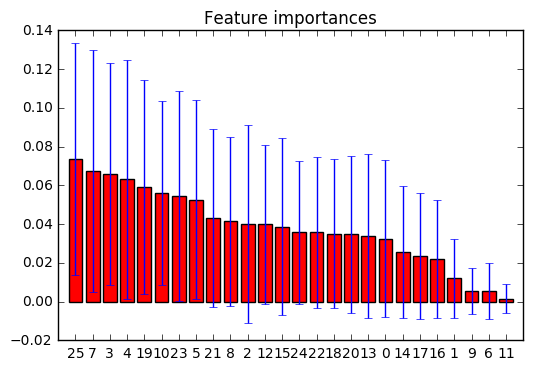

In [41]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

clf = LogisticRegression()
clf.fit(features_train, labels_train)  # your feature and labels
model = SelectFromModel(clf, prefit=True)

# Build a classification task using 3 informative features
X, y = features_train, labels_train

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, features_list[1:][f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

### Gridsearch final algorithm with final parameters can be seen below
N-estimators = 10, Max_depth = 1, All features are used

In [42]:
from sklearn.model_selection import GridSearchCV
# applying GridSearch on GradientBoostingClassifier only

param_grid = {'n_estimators': [10, 100, 1000],'max_depth': [1, 2, 5]}


grid_search = GridSearchCV(GradientBoostingClassifier(), cv=10, n_jobs=-1, param_grid=param_grid)
grid_search.fit(features_train, labels_train)
clf = grid_search.best_estimator_

print clf
print grid_search.best_estimator_.score(features_test, labels_test)
print grid_search.grid_scores_

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=1,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=10, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)
0.862068965517
[mean: 0.87931, std: 0.03421, params: {'n_estimators': 10, 'max_depth': 1}, mean: 0.83621, std: 0.06740, params: {'n_estimators': 100, 'max_depth': 1}, mean: 0.79310, std: 0.05349, params: {'n_estimators': 1000, 'max_depth': 1}, mean: 0.85345, std: 0.04773, params: {'n_estimators': 10, 'max_depth': 2}, mean: 0.81034, std: 0.06369, params: {'n_estimators': 100, 'max_depth': 2}, mean: 0.78448, std: 0.08050, params: {'n_estimators': 1000, 'max_depth': 2}, mean: 0.81897, std: 0.04036, params: {'n_estimators': 10, 'max_depth': 5}, mean: 0.81897, std: 0.0

#### Gridseach with PCA

In [43]:
# applying grid search on GradientBoostingClassifier but with pipeline which inludes PCA
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
estimators = [('reduce_dim', PCA()), ('clf', GradientBoostingClassifier())]
pipe = Pipeline(estimators)
 

#param_grid = dict(selectkbest__k = range(20,25))

param_grid = {'reduce_dim__n_components': [2, 3],
               'clf__max_depth': [5,6]
          }

grid_search = GridSearchCV(pipe, cv=10, n_jobs=-1, param_grid = param_grid)
grid_search.fit(features_train, labels_train)
clf = grid_search.best_estimator_

print clf
print grid_search.best_estimator_.score(features_test, labels_test)
print grid_search.grid_scores_

Pipeline(steps=[('reduce_dim', PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_featur...=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False))])
0.862068965517
[mean: 0.85345, std: 0.06526, params: {'clf__max_depth': 5, 'reduce_dim__n_components': 2}, mean: 0.85345, std: 0.07689, params: {'clf__max_depth': 5, 'reduce_dim__n_components': 3}, mean: 0.85345, std: 0.06526, params: {'clf__max_depth': 6, 'reduce_dim__n_components': 2}, mean: 0.85345, std: 0.09227, params: {'clf__max_depth': 6, 'reduce_dim__n_components': 3}]


In [55]:
'''
clf_final = GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=1,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=10, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)
clf = clf_final.fit(features_train, labels_train)
pred = clf_final.predict(features_test)
acc=accuracy_score(labels_test, pred)
print 'Accuracy before tuning, GradientBoosting  =', acc
print 'precision = ', precision_score(labels_test,pred)
print 'recall = ', recall_score(labels_test,pred)
'''

"\nclf_final = GradientBoostingClassifier(criterion='friedman_mse', init=None,\n              learning_rate=0.1, loss='deviance', max_depth=1,\n              max_features=None, max_leaf_nodes=None,\n              min_impurity_split=1e-07, min_samples_leaf=1,\n              min_samples_split=2, min_weight_fraction_leaf=0.0,\n              n_estimators=10, presort='auto', random_state=None,\n              subsample=1.0, verbose=0, warm_start=False)\nclf = clf_final.fit(features_train, labels_train)\npred = clf_final.predict(features_test)\nacc=accuracy_score(labels_test, pred)\nprint 'Accuracy before tuning, GradientBoosting  =', acc\nprint 'precision = ', precision_score(labels_test,pred)\nprint 'recall = ', recall_score(labels_test,pred)\n"

### References
* http://scikit-learn.org/stable/modules/ensemble.html#gradient-boosting
* http://scikit-learn.org/stable/modules/pipeline.html
* http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
* https://stackoverflow.com/questions/26266362/how-to-count-the-nan-values-in-the-column-in-panda-data-frame
* http://chris-said.io/2016/02/13/how-to-make-polished-jupyter-presentations-with-optional-code-visibility/
